In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import random
import matplotlib.pyplot as plt

In [2]:
# Чтобы датасет возвращал тензоры, а не  PIL.Image объекты, добавим трансформации
# Нормализуем данные для более легкого обучения модели (mean, std посчитаны)
transform=transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = torchvision.datasets.MNIST(root='.', transform=transform, download=True)
test_dataset  = torchvision.datasets.MNIST(root='.', transform=transform, train=False, download=True)
train_dataset[0][0].shape

torch.Size([1, 224, 224])

Digit: 1


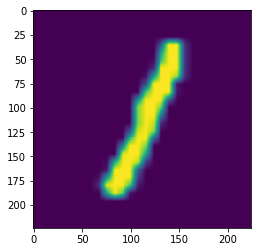

In [5]:
ind = random.randint(0, len(train_dataset)-1)
plt.imshow(train_dataset[ind][0].squeeze(0))
print('Digit:', train_dataset[ind][1])

In [6]:
# Данные из датасета в модель будет отправлять Dataloader.
# Он отвечает за сэмплирование данных, чтение (в т.ч. параллельное) с диска и собирание данных в батчи
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=True, num_workers=4)

In [7]:
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        ### Your code here
        self.conv1 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.conv2 = nn.Conv2d(channels, channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.bn2 = nn.BatchNorm2d(channels)
    
    def forward(self, x):
        ### Your code here
        res = x
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = x + res
        x = self.bn2(x)
        x = F.relu(x)
        return x

In [65]:
class ResNet(nn.Module):
    def __init__(self):
        super(ResNet, self).__init__()
        ### Your code here
        self.conv0 = nn.Conv2d(1, 64, 7, 2, 3)
        self.maxpool = nn.MaxPool2d(3, 2, 1)
        
        self.res0 = nn.ModuleList([ResBlock(64) for i in range(3)])
        
        self.conv1_proj = nn.Conv2d(64, 128, 1, 2, 0)
        self.conv1_0 = nn.Conv2d(64, 128, 3, 2, 1)
        self.conv1_1 = nn.Conv2d(128, 128, 3, 1, 1)
        self.bn1_0 = nn.BatchNorm2d(128)
        self.bn1_1 = nn.BatchNorm2d(128)        
        self.res1 = nn.ModuleList([ResBlock(128) for i in range(3)])
        
        self.conv2_proj = nn.Conv2d(128, 256, 1, 2, 0)
        self.conv2_0 = nn.Conv2d(128, 256, 3, 2, 1)
        self.conv2_1 = nn.Conv2d(256, 256, 3, 1, 1)
        self.bn2_0 = nn.BatchNorm2d(256)
        self.bn2_1 = nn.BatchNorm2d(256)        
        self.res2 = nn.ModuleList([ResBlock(256) for i in range(5)])
        
        self.conv3_proj = nn.Conv2d(256, 512, 1, 2, 0)
        self.conv3_0 = nn.Conv2d(256, 512, 3, 2, 1)
        self.conv3_1 = nn.Conv2d(512, 512, 3, 1, 1)
        self.bn3_0 = nn.BatchNorm2d(512)
        self.bn3_1 = nn.BatchNorm2d(512)
        self.res3 = nn.ModuleList([ResBlock(512) for i in range(2)])
        
        self.linear = nn.Linear(512, 10)
        
    def forward(self, x):
        ### Your code here
        x = self.conv0(x)
        x = self.maxpool(x)
        for resblock in self.res0:
            x = resblock(x)
        
        res = self.conv1_proj(x)
        x = self.conv1_0(x)
        x = self.bn1_0(x)
        x = F.relu(x)
        x = self.conv1_1(x)
        x = x + res
        x = self.bn1_1(x)
        x = F.relu(x)
        for resblock in self.res1:
            x = resblock(x)
            
        res = self.conv2_proj(x)
        x = self.conv2_0(x)
        x = self.bn2_0(x)
        x = F.relu(x)
        x = self.conv2_1(x)
        x = x + res
        x = self.bn2_1(x)
        x = F.relu(x)
        for resblock in self.res2:
            x = resblock(x)
            
        res = self.conv3_proj(x)
        x = self.conv3_0(x)
        x = self.bn3_0(x)
        x = F.relu(x)
        x = self.conv3_1(x)
        x = x + res  
        x = self.bn3_1(x)
        x = F.relu(x)
        for resblock in self.res3:
            x = resblock(x)
            
        x = x.mean(dim=[2, 3])
        x = self.linear(x)
        
        return x

In [66]:
resnet = ResNet()
x = torch.randn(2, 1, 224, 224)
print(resnet(x).shape)

torch.Size([2, 10])


In [67]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = ResNet().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

num_epochs = 3
for epoch in range(num_epochs):
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 40 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_dataloader.dataset),
                100. * batch_idx / len(train_dataloader), loss.item()))
    ### YOUR CODE HERE:
    # print test set accuracy after each epoch

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.309625
Train Epoch: 0 [10240/60000 (17%)]	Loss: 1.893195
Train Epoch: 0 [20480/60000 (34%)]	Loss: 1.536962
Train Epoch: 0 [30720/60000 (51%)]	Loss: 1.122654
Train Epoch: 0 [40960/60000 (68%)]	Loss: 0.720539
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.412227
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.360761
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.245708
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.182675
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.146739
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.109468
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.114828
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.072703
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.134611
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.105601
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.072307
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.065803
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.076453


### Мы увидели, что лосс продолжает падать, так что несмотря на то, что предсказания неточные, есть смысл модель дообучить

Выводы:
1. Стоит итеративно дебажить модель, чтобы сразу находить ошибки
2. Читать пейперы внимательно, иногда важные моменты (Batch Norm) написаны чуть ли не мелким шрифтом непонятно где, и это легко пропустить
3. Всегда можно распечатать справку по нужному слою либо посмотреть в документацию пайторча, где в том числе покажут примеры применения
4. Если непонятно, применимо ли что-то в вашем случае, всегда можно создать dummy переменную, прогнать через модель/слой/функцию, и убедиться, что все работает так, как нужно


Digit: 5 Pred: 9


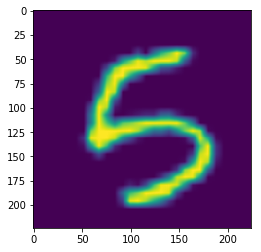

In [77]:
ind = random.randint(0, len(test_dataset)-1)
plt.imshow(test_dataset[ind][0].squeeze(0))
print('Digit:', test_dataset[ind][1], 'Pred:', torch.argmax(model(test_dataset[ind][0].unsqueeze(0).to(device))).item())

In [ ]:
model(test_dataset[10][0].unsqueeze(0).to(device))